<a href="https://colab.research.google.com/github/ibrahimgh25/CutterKit/blob/master/CartPole_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file implements the q-learning algorithm on the 'CartPole-v0' environment provided by the gym package. This is the first thing I actually used q_learning on, (I mean instead of just playing around with someones code), the code is based on a code from pythonprograming.net where they use q_learning to solve the mountain cart problem (link: https://pythonprogramming.net/q-learning-analysis-reinforcement-learning-python-tutorial/), that's actually were I learned to implement the algorithm. The results I got are ok, I think I can stop the algorithm at around 32000 episodes for the best results. I first had a problem with the obsurd limits on the observation space (the accelaration and velocity of the pole can go up to 1e38!!) which would create a problem in discretization, I solved it by applying a max boundary for these values where all values above some max_ceil(above 200 for example) are put equal to the max_ceil(200 in our example), the same went with the min boundaries too. I experimented with various parameters, but not a lot with the ceil, which I think is very important, I also discretisized the whole observation space into the same number of levels, but that can also be tuned by choosing lower number of levels for less important parameters (or ones that aren't affected much with harsh discretization) and higher or same discretization levels for parameters which are more affected. But I decided to stop at that to learn other stuff.

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

class cartPole_agent():
  def __init__(self, learning_rate=0.1, discount=0.999, epsilon=1,
               start_epsilon_decaying=1, end_epsilon_decaying=30000,
               discretization_levels=20, q_init_low=-1, q_init_high=1):

    self.env = gym.make("CartPole-v0")
    self.options = self.env.action_space.n
    self.learning_rate = learning_rate
    self.discount = discount
    self.log = f"agent_log_lr({learning_rate}_discount({discount}_dl({discretization_levels}"
    if not os.path.exists(self.log):
      os.mkdir(self.log)
    self.epsilon = epsilon
    self.start_epsilon_decaying = start_epsilon_decaying
    self.end_epsilon_decaying = end_epsilon_decaying
    # Caculate the value to be subtracted from epsilon at each episode
    decayed_episodes = end_epsilon_decaying - start_epsilon_decaying
    self.epsilon_decay_value = epsilon / decayed_episodes

    obs_high = adjustObs(self.env.observation_space.high)
    obs_low = adjustObs(self.env.observation_space.low)
    # Save obs_low since it's needed in getDiscreteState to avoid calculating it
    # at each iteration
    self.obs_low = obs_low
    # Get the number of states and calculate the window size to be used in 
    # discretization
    self.DISC_OS_SIZE = [discretization_levels] * len(obs_low)
    self.DISC_OS_WIN_SIZE = (obs_high - obs_low)/self.DISC_OS_SIZE
    self.q_table = np.random.uniform(low=q_init_low, high=q_init_high,
                                      size=(self.DISC_OS_SIZE + [self.options]))

    self.ep_rewards = []
    self.aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}


  def getAction(self, discrete_state):
    # Returns the action given a discrete state
    if np.random.random() > self.epsilon:
      return np.argmax(self.q_table[discrete_state])
    else:
      return np.random.randint(0, self.options)

  def getDiscreteState(self, state):
    # Returns a discrete state given a continous state
    state = adjustObs(state)
    discrete_state = (state - self.obs_low) / self.DISC_OS_WIN_SIZE
    return tuple(discrete_state.astype(int))

  def playOnce(self, episode, stats_every=200, suppress_output=False,
               save_every=500):
    done = False
    discrete_state = self.getDiscreteState(self.env.reset())
    episode_reward = 0
    steps = 0

    while not done:
      action = self.getAction(discrete_state)
      new_state, reward, done, _ = self.env.step(action)
      steps += 1
      episode_reward += reward
      new_discrete_state = self.getDiscreteState(new_state)

      if not done: # Typical q_learning algorithm
        max_future_q = np.max(self.q_table[new_discrete_state])
        current_q = self.q_table[discrete_state + (action, )]
        new_q = (
            (1 - self.learning_rate) * current_q 
            + self.learning_rate * (reward + self.discount * max_future_q)
            )
        self.q_table[discrete_state + (action, )] = new_q

      else: # If done then the future rewards at this action is expected to be 0 
        self.q_table[discrete_state + (action, )] = 0
      
      discrete_state = new_discrete_state

    if self.end_epsilon_decaying >= episode >= self.start_epsilon_decaying:
        self.epsilon -= self.epsilon_decay_value
    # Add episode reward is added to the reward-set of the agent  
    self.ep_rewards.append(episode_reward)
    if not episode % stats_every:
      average_reward = sum(self.ep_rewards[-stats_every:])/stats_every
      self.aggr_ep_rewards['ep'].append(episode)
      self.aggr_ep_rewards['avg'].append(average_reward)
      self.aggr_ep_rewards['max'].append(max(self.ep_rewards[-stats_every:]))
      self.aggr_ep_rewards['min'].append(min(self.ep_rewards[-stats_every:]))
      if not suppress_output:
        print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {self.epsilon:>1.2f}')

    # Save the q_table
    if not episode % save_every and not suppress_output:
      file_name = self.log + "/agent_E" + adjustString(episode)
      pickle.dump(self, open(file_name, 'wb'))

  def display_results(self):
    # A funcatoin to plot the results of training, the figure is saved for 
    # future reference
    plt.plot(self.aggr_ep_rewards['ep'], self.aggr_ep_rewards['avg'],
             label="average rewards")
    plt.plot(self.aggr_ep_rewards['ep'], self.aggr_ep_rewards['max'],
             label="max rewards")
    plt.plot(self.aggr_ep_rewards['ep'], self.aggr_ep_rewards['min'],
             label="min rewards")
    plt.legend(loc=1)
    plt.savefig('figure.jpg')
    plt.show()


def adjustObs(obs, max_value=200):
  # The limits of the observation space can get to very large numbers (1e37 for 
  # example), so it's necessary to put a bound on it, else self.DISC_OS_WIN_SIZE
  # would be considered infinite during the calculation (specifically at
  # indecies 1 and 3)
  for index, value in enumerate(obs):
    if value > max_value: obs[index] = max_value
    if value < -max_value: obs[index] = -max_value
  return obs

def adjustString(integer_number, intended_digits=5):
  # To return a better formatted number when naming agents, the saved file will
  # be identified by the number of episode it was saved on, for example we need 
  # the numbering to be 001 002 ... 100 instead of 1 2 ... 100 which will be 
  # better visually and sorted correctly every where (a lot of systems sort 100 
  # before 2 which would be a problem)
  def count_digits(integer_number):
    # Counts number of digits in given an integer by continously dividing by 10
    number_of_digits = 0
    while integer_number > 10:
      integer_number = integer_number // 10
      number_of_digits += 1
    return number_of_digits
  
  digits = count_digits(integer_number)
  string = ''
  # Here we didn't handle for when the digits of the input number are higher 
  # than the intended digits, we depend on our ability to use the function correctly...
  for _ in range(intended_digits - digits):
    string += '0'
  return string + str(integer_number)
  


In [ ]:
EPISODES = 50_000
# Create the agent and train it for 50_000 episodes
play_ground = cartPole_agent(learning_rate=0.1, discount=0.999, epsilon=1,
               start_epsilon_decaying=1, end_epsilon_decaying=30_000,
               discretization_levels=32, q_init_low=0, q_init_high=70)

for episode in range(EPISODES):
  play_ground.playOnce(episode)


Episode:     0, average reward:  0.2, current epsilon: 1.00
Episode:   200, average reward: 22.7, current epsilon: 0.99
Episode:   400, average reward: 22.9, current epsilon: 0.99
Episode:   600, average reward: 22.5, current epsilon: 0.98
Episode:   800, average reward: 21.7, current epsilon: 0.97
Episode:  1000, average reward: 22.5, current epsilon: 0.97
Episode:  1200, average reward: 24.1, current epsilon: 0.96
Episode:  1400, average reward: 23.3, current epsilon: 0.95
Episode:  1600, average reward: 21.7, current epsilon: 0.95
Episode:  1800, average reward: 23.2, current epsilon: 0.94
Episode:  2000, average reward: 23.9, current epsilon: 0.93
Episode:  2200, average reward: 24.9, current epsilon: 0.93
Episode:  2400, average reward: 25.3, current epsilon: 0.92
Episode:  2600, average reward: 25.0, current epsilon: 0.91
Episode:  2800, average reward: 24.8, current epsilon: 0.91
Episode:  3000, average reward: 27.3, current epsilon: 0.90
Episode:  3200, average reward: 26.2, cu

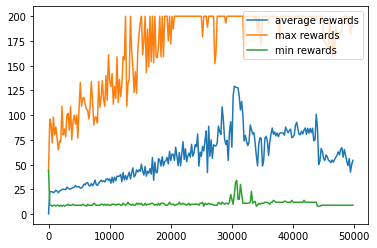

In [ ]:
# Plot the results of training, it seems that the optimal point was at
# about 30_000 episodes where we got the higher avg and min rewards.
play_ground.display_results()

In [ ]:
# For testing different parameters (when to end epsilon decaying, what effect 
# does changing max initialized q_value on the rewards, and what is the optimal 
# discretization level)

EPISODES = 50_000

end_epsilon_decaying_list = [40_000, 50_000, 30_000]
discretization_levels_list = [20, 26, 32]
q_init_high_list = [50, 60, 70]
results = []
for end_epsilon_decaying in end_epsilon_decaying_list:
  for discretization_level in discretization_levels_list:
    for q_init_high in q_init_high_list:
      play_ground = cartPole_agent(learning_rate=0.1, discount=0.999, epsilon=1,
                                    start_epsilon_decaying=1, end_epsilon_decaying=end_epsilon_decaying,
                                    discretization_levels=discretization_level, q_init_low=0, q_init_high=q_init_high)
    for episode in range(EPISODES):
      play_ground.playOnce(episode, suppress_output=True)
    results.append(([end_epsilon_decaying, discretization_level, q_init_high], play_ground.aggr_ep_rewards))
    # print(play_ground.aggr_ep_rewards['avg'])
    mean = np.nanmean(play_ground.aggr_ep_rewards['avg'])
    print(f'for end_epsilon_decaying={end_epsilon_decaying} and discretization_levels={discretization_level} and q_init_high={q_init_high} average_rewards = {mean}')

for end_epsilon_decaying=40000 and discretization_levels=20 and q_init_high=70 average_rewards = 59.443180000000005
for end_epsilon_decaying=40000 and discretization_levels=26 and q_init_high=70 average_rewards = 56.865520000000004
for end_epsilon_decaying=40000 and discretization_levels=32 and q_init_high=70 average_rewards = 53.25287999999999
for end_epsilon_decaying=50000 and discretization_levels=20 and q_init_high=70 average_rewards = 48.33992
for end_epsilon_decaying=50000 and discretization_levels=26 and q_init_high=70 average_rewards = 47.236419999999995
for end_epsilon_decaying=50000 and discretization_levels=32 and q_init_high=70 average_rewards = 47.61938000000001
for end_epsilon_decaying=30000 and discretization_levels=20 and q_init_high=70 average_rewards = 61.127199999999995
for end_epsilon_decaying=30000 and discretization_levels=26 and q_init_high=70 average_rewards = 54.46542
for end_epsilon_decaying=30000 and discretization_levels=32 and q_init_high=70 average_rewards

In [ ]:
# Viewing more details of the above experiment
for parameters, agg_ep_rewards in results:
  print(parameters, ':')
  print(np.max(agg_ep_rewards['avg']))
  print(np.max(agg_ep_rewards['min']))

[40000, 20, 70] :
131.25
40.0
[40000, 26, 70] :
144.38
39.0
[40000, 32, 70] :
127.29
25.0
[50000, 20, 70] :
134.63
48.0
[50000, 26, 70] :
137.98
61.0
[50000, 32, 70] :
126.07
42.0
[30000, 20, 70] :
117.0
72.0
[30000, 26, 70] :
136.04
24.0
[30000, 32, 70] :
122.76
29.0


In [ ]:
# For testing different parameters (optimal learning_rate, what effect 
# does changing discount_value have on the rewards

discount_list = [0.8, 0.9, 0.95, 0.99, 0.999]
learning_rate_list = [0.1, 0.01, 0.05]
results_2 = []
for discount in discount_list:
  for learning_rate in learning_rate_list:
    play_ground = cartPole_agent(learning_rate=learning_rate, discount=discount, epsilon=1,
                                    start_epsilon_decaying=1, end_epsilon_decaying=30_000,
                                    discretization_levels=32, q_init_low=0, q_init_high=70)
    for episode in range(EPISODES):
      play_ground.playOnce(episode, suppress_output=True)
    results_2.append(([discount, learning_rate], play_ground.aggr_ep_rewards))
    # print(play_ground.aggr_ep_rewards['avg'])
    mean = np.nanmean(play_ground.aggr_ep_rewards['avg'])
    print(f'for learning_rate={learning_rate} and discount={discount} average_rewards = {mean}')

for learning_rate=0.1 and discount=0.8 average_rewards = 52.40506
for learning_rate=0.01 and discount=0.8 average_rewards = 47.0495
for learning_rate=0.05 and discount=0.8 average_rewards = 49.399119999999996
for learning_rate=0.1 and discount=0.9 average_rewards = 58.62442000000001
for learning_rate=0.01 and discount=0.9 average_rewards = 68.44892000000002
for learning_rate=0.05 and discount=0.9 average_rewards = 52.81204
for learning_rate=0.1 and discount=0.95 average_rewards = 59.77066000000001
for learning_rate=0.01 and discount=0.95 average_rewards = 65.7031
for learning_rate=0.05 and discount=0.95 average_rewards = 59.8812
for learning_rate=0.1 and discount=0.99 average_rewards = 70.78017999999999
for learning_rate=0.01 and discount=0.99 average_rewards = 69.40374
for learning_rate=0.05 and discount=0.99 average_rewards = 68.74406
for learning_rate=0.1 and discount=0.999 average_rewards = 71.51466
for learning_rate=0.01 and discount=0.999 average_rewards = 51.290020000000005
for 

In [ ]:
# Viewing more details of the above experiment
for parameters, agg_ep_rewards in results_2:
  print(parameters, ':')
  print(np.max(agg_ep_rewards['avg']))
  print(np.max(agg_ep_rewards['min']))

[0.8, 0.1] :
96.56
49.0
[0.8, 0.01] :
110.71
40.0
[0.8, 0.05] :
106.63
27.0
[0.9, 0.1] :
119.56
26.0
[0.9, 0.01] :
124.64
43.0
[0.9, 0.05] :
96.07
22.0
[0.95, 0.1] :
119.12
51.0
[0.95, 0.01] :
127.77
50.0
[0.95, 0.05] :
139.5
93.0
[0.99, 0.1] :
161.65
93.0
[0.99, 0.01] :
119.59
39.0
[0.99, 0.05] :
132.21
39.0
[0.999, 0.1] :
132.32
62.0
[0.999, 0.01] :
109.18
33.0
[0.999, 0.05] :
123.11
48.0
